In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("/Users/yecortez/Downloads/credit_card_transactions.csv")

In [3]:
data['Date'] = pd.to_datetime(data['trans_date_trans_time'])

In [4]:
data = data[["Date","amt","trans_num"]]

In [19]:
data_daily = data.resample('D', on='Date').agg({'amt': 'sum','trans_num':'count'}).reset_index()

In [20]:
data_daily['Day'] = data_daily['Date'].dt.day
data_daily['Month'] = data_daily['Date'].dt.month
data_daily['Year'] = data_daily['Date'].dt.year
data_daily['Weekday'] = data_daily['Date'].dt.weekday 

In [21]:
data_daily

,Date,amt,trans_num,Day,Month,Year,Weekday
0,2019-01-01,156487.09,2414,1,1,2019,1
1,2019-01-02,70723.58,1118,2,1,2019,2
2,2019-01-03,86516.49,1236,3,1,2019,3
3,2019-01-04,112436.39,1474,4,1,2019,4
4,2019-01-05,97496.13,1409,5,1,2019,5
...,...,...,...,...,...,...,...
533,2020-06-17,141792.48,1812,17,6,2020,2
534,2020-06-18,166713.71,2028,18,6,2020,3
535,2020-06-19,176152.74,2413,19,6,2020,4
536,2020-06-20,172070.93,2354,20,6,2020,5


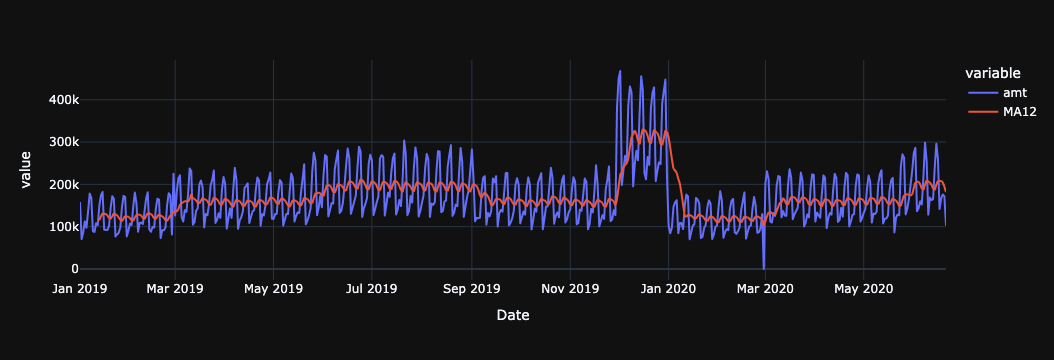

In [22]:
# create 12 month moving average
data_daily['MA12'] = data_daily['amt'].rolling(12).mean()

# plot the data and MA
import plotly.express as px
fig = px.line(data_daily, x="Date", y=["amt", "MA12"], template = 'plotly_dark')
fig.show()

In [23]:
data_daily.drop(['MA12'], axis=1, inplace=True)

In [24]:
train = data_daily[data_daily['Date'] <= '2019-12-31']
test = data_daily[data_daily['Date'] >= '2020-01-01']
train.shape, test.shape

((365, 7), (173, 7))

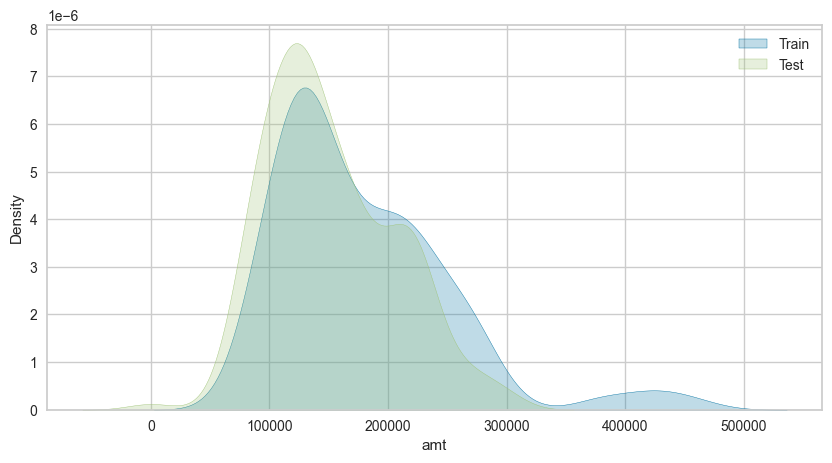

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.kdeplot(train["amt"], label="Train", shade=True)
sns.kdeplot(test["amt"], label="Test", shade=True)
plt.legend()
plt.show()

In [142]:
from pycaret.regression import *
s = setup(data=train, 
          test_data=test, 
          target='amt', 
          fold_strategy='timeseries', 
          numeric_features=['Day', 'Month', 'Year', 'Weekday'], 
          fold=3, 
          session_id=123,
          data_split_shuffle=False,  
          fold_shuffle=False)


,Description,Value
0,Session id,123
1,Target,amt
2,Target type,Regression
3,Original data shape,"(538, 7)"
4,Transformed data shape,"(538, 9)"
5,Transformed train set shape,"(365, 9)"
6,Transformed test set shape,"(173, 9)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


In [143]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lar,Least Angle Regression,7902.0761,103178594.6918,10091.6677,0.9771,0.0525,0.0424,0.0267
llar,Lasso Least Angle Regression,7902.1497,103178646.3494,10091.6707,0.9771,0.0525,0.0424,0.0267
lasso,Lasso Regression,7934.3176,105017669.9340,10175.4900,0.9768,0.0533,0.0425,1.2400
lr,Linear Regression,7934.3759,105022263.6533,10175.7143,0.9768,0.0533,0.0425,3.4400
ridge,Ridge Regression,7934.4211,105008673.2055,10174.9703,0.9768,0.0533,0.0425,1.3267
en,Elastic Net,7937.8319,104533525.7584,10151.0163,0.9769,0.0531,0.0426,1.1600
br,Bayesian Ridge,8027.8559,104324796.0525,10162.6760,0.9765,0.0531,0.0434,0.0200
omp,Orthogonal Matching Pursuit,8072.1469,104127545.7777,10154.9075,0.9766,0.0530,0.0437,0.0167
huber,Huber Regressor,8373.8954,115230697.3724,10698.5811,0.9738,0.0555,0.0449,0.0300
par,Passive Aggressive Regressor,13155.9160,253816300.6651,15412.7734,0.9340,0.0843,0.0760,1.2033


In [30]:
best

Lars(random_state=123)

In [281]:
prediction_holdout = predict_model(best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,6564.5831,72948820.6966,8541.0082,0.9749,0.5803,0.0471


In [294]:
predictions=predict_model(best, data=data_daily)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,7218.8167,85737052.5553,9259.4305,0.9821,0.3321,0.0451


In [283]:
predictions

,Date,trans_num,Day,Month,Year,Weekday,amt,prediction_label
0,2019-01-01,2414,1,1,2019,1,156487.093750,170827.910239
1,2019-01-02,1118,2,1,2019,2,70723.578125,80078.344714
2,2019-01-03,1236,3,1,2019,3,86516.492188,87865.568082
3,2019-01-04,1474,4,1,2019,4,112436.390625,104015.178059
4,2019-01-05,1409,5,1,2019,5,97496.132812,99049.761846
...,...,...,...,...,...,...,...,...
533,2020-06-17,1812,17,6,2020,2,141792.484375,128383.776258
534,2020-06-18,2028,18,6,2020,3,166713.703125,143000.282024
535,2020-06-19,2413,19,6,2020,4,176152.734375,169393.815599
536,2020-06-20,2354,20,6,2020,5,172070.937500,164846.518717


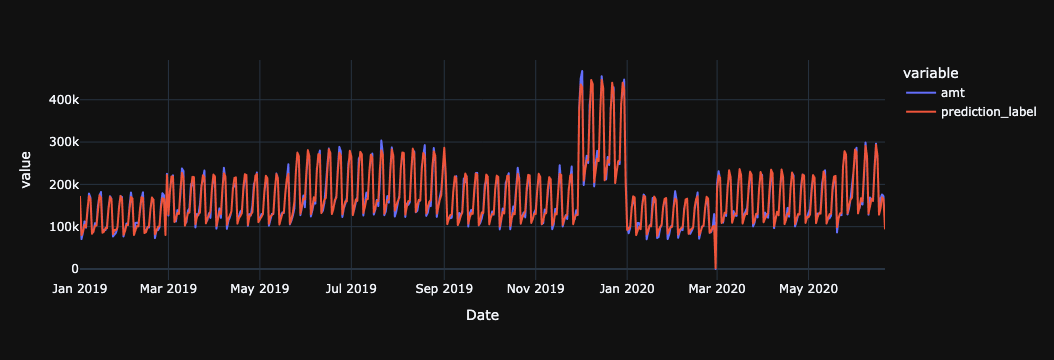

In [295]:
import plotly.express as px
fig = px.line(predictions, x='Date', y=["amt", "prediction_label"], template = 'plotly_dark')
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,6564.5831,72948820.6966,8541.0082,0.9749,0.5803,0.0471


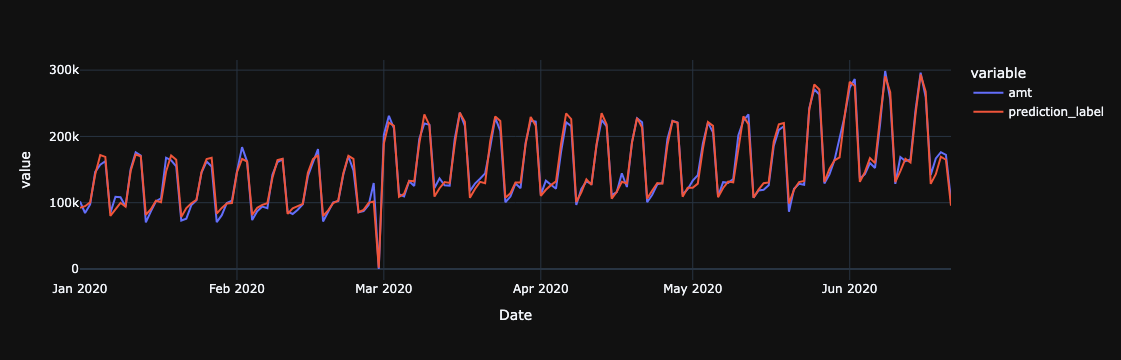

In [45]:
predictions=predict_model(best, data=test)
import plotly.express as px
fig = px.line(predictions, x='Date', y=["amt", "prediction_label"], template = 'plotly_dark')
fig.show()

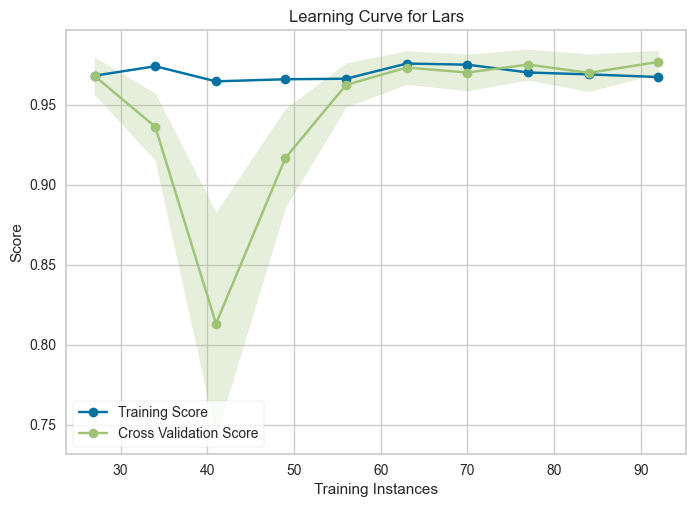

In [46]:
plot_model(best,plot='learning')

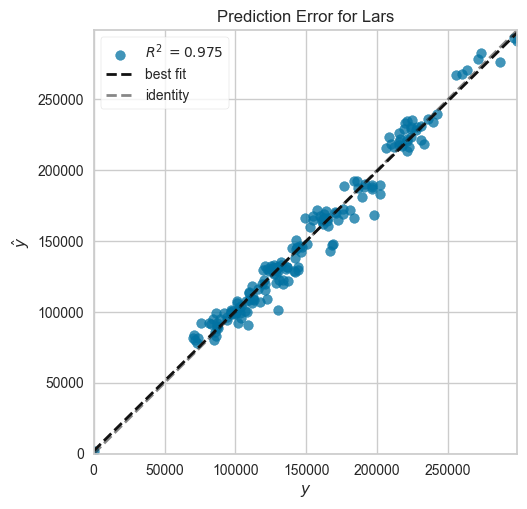

In [47]:
plot_model(best, plot='error')

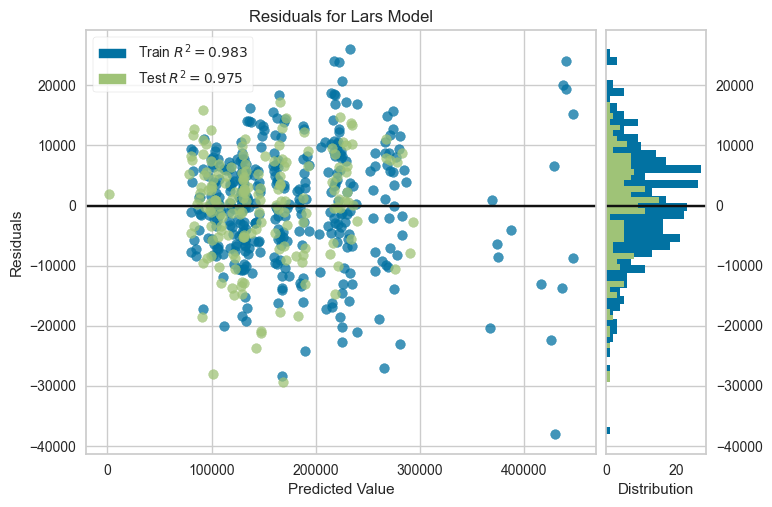

In [48]:
plot_model(best,plot="residuals")

In [61]:
final_best = finalize_model(best)

In [71]:
final_best

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['Date'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['Day', 'Month', 'Year', 'Weekday'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator', Lars(random_state=123))])

Pronostico a futuro

In [ ]:
future_dates = pd.date_range(start = '2020-06-22', end = '2020-08-22', freq = 'D')

future_df = pd.DataFrame()

future_df['Date'] = pd.date_range(start='2020-06-22', end = '2020-08-22', freq = 'D')
future_df['Day'] = [i.day for i in future_dates]
future_df['Month'] = [i.month for i in future_dates]
future_df['Year'] = [i.year for i in future_dates] 
future_df['Weekday'] = [i.weekday() for i in future_dates]

Aplicando simulación de Montecarlo para obtener cantidad de transacciones para pronosticar a futuro

In [276]:
media_trans = train['trans_num'].mean()
std_trans = train['trans_num'].std()

# Generar transacciones simuladas con Montecarlo (usando una distribución normal)
np.random.seed(42)  # Para reproducibilidad
future_df['trans_num'] = np.random.normal(media_trans, std_trans, len(future_df)).astype(int)

# Asegurar que no haya valores negativos
future_df['trans_num'] = future_df['trans_num'].apply(lambda x: max(x, 0))

In [277]:
predictions_future = predict_model(final_best, data=future_df)

In [278]:
concat_df = pd.concat([data_daily,predictions_future], axis=0)
concat_df_i = pd.date_range(start='2019-01-01', end = '2020-08-22', freq = 'D')

In [279]:
concat_df.set_index(concat_df_i, inplace=True)

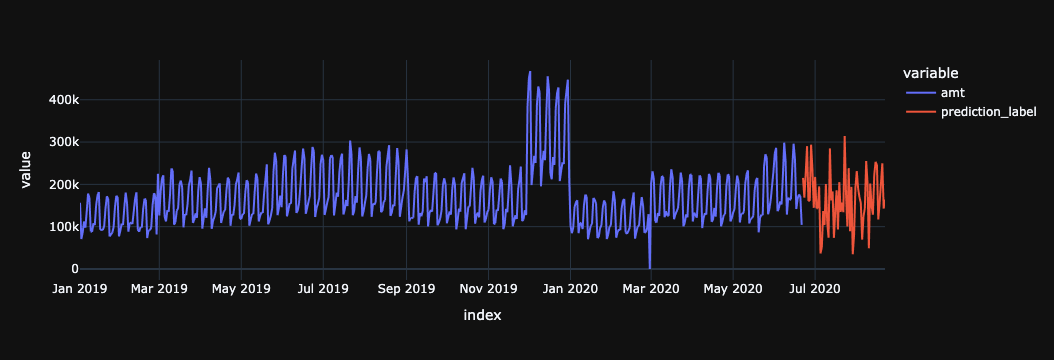

In [280]:
fig = px.line(concat_df, x=concat_df.index, y=["amt", "prediction_label"], template = 'plotly_dark')
fig.show()